In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ripser
import persim

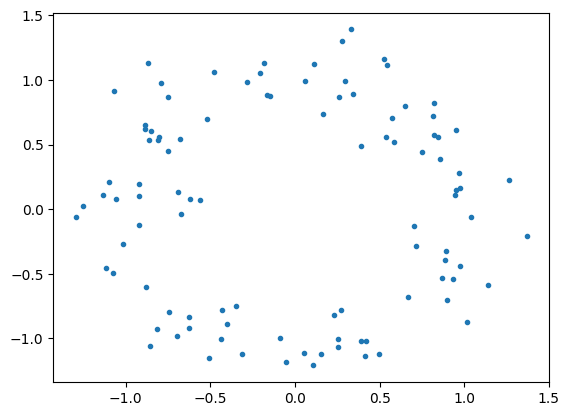

In [9]:
# reading the circle
X = np.loadtxt("../R/unitCircle.csv", skiprows=1, delimiter=",")
plt.plot(X[:,0], X[:,1], ".")

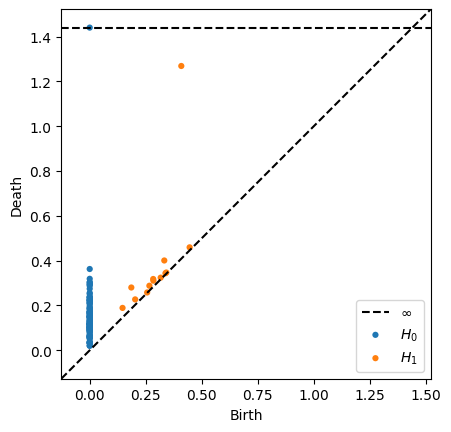

In [23]:
D = ripser.ripser(X, thresh=2)["dgms"]
persim.plot_diagrams(D)

In [37]:
def DiagToPD(D):
    PD = [pd.DataFrame({"dim":dim, "b":D[dim][:,0], "p":D[dim][:,1]}) for dim in range(len(D))]
    PD = pd.concat(PD)
    return PD


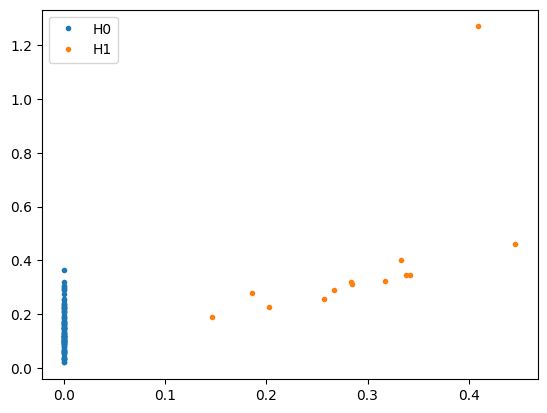

In [46]:
PD = DiagToPD(D)
for dim in PD["dim"].drop_duplicates():
    pd_ = PD[PD["dim"]==dim]
    plt.plot(pd_["b"], pd_["p"], ".", label = "H"+str(dim))
plt.legend()